In [80]:
import sys
import os
import pickle
import logging
from imp import reload
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
#plt.style.use('papers')
%matplotlib inline
import sklearn.decomposition as skd
import chianti.core as ch
research_root = '/Users/willbarnes/Documents/Rice/Research'
sys.path.append(os.path.join(research_root,'solarnmf'))
sys.path.append(os.path.join(research_root,'EBTEL_repo/bin/'))
sys.path.append(os.path.join(research_root,'EBTEL_analysis/src/'))
import solarnmf as snf
import ebtel_wrapper as ebw
import em_binner as emb
reload(snf)
reload(emb)

<module 'em_binner' from '/Users/willbarnes/Documents/Rice/Research/EBTEL_analysis/src/em_binner.py'>

# Event Detection in Forward Modeled Light Curves
Use EBTEL to create synthetic light curves and then use NMF to try and detect the number of events in this light curve.

## EBTEL Run
First, run the EBTEL model for a couple of heating events and get a temperature and density profile.

In [57]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 5
config_dict['t_pulse_half'] = 25
config_dict['h_nano'] = 0.4
config_dict['sample_rate'] = 50
config_dict['output_file'] = os.path.join(research_root,'research_notebook/NMF/ebtel_light_curve_test')
config_dict['start_time_array'] = np.array([0.0,1020.0,3000.0,3060.0,4025.0])
config_dict['end_time_array'] = 2.*config_dict['t_pulse_half'] + config_dict['start_time_array']

In [58]:
#print input file
ebw.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')
#run model
ebw.run_ebtel(os.path.join(research_root,'EBTEL_repo/bin/'),'',config_file=config_dict['output_file']+'.xml',verbose=False)

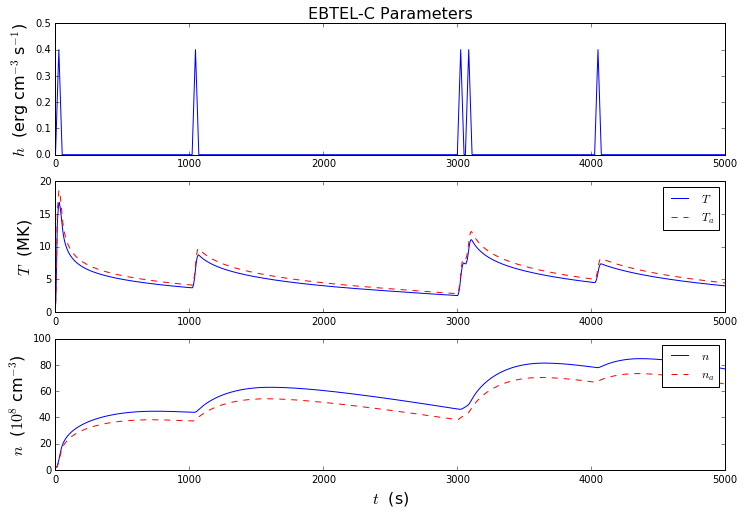

In [59]:
#plot result
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [60]:
#Load data
data = np.loadtxt(config_dict['output_file']+'.txt')
t_ebtel = data[:,0]
T_ebtel = data[:,1]
n_ebtel = data[:,2]

## Forward-modeled Light Curve
Now, we want to use the resulting temperature and density to calculate a light curve.

### Differential Emission Measure, $\mathrm{DEM}(T)$

First, calculate the differential emission measure. Here, we'll only use the coronal component which shouldn't be a problem given the temperatures that we care about.

In [61]:
binner = emb.EM_Binner(t_ebtel,T_ebtel,n_ebtel,2.0*config_dict['loop_length']*1.e+8)

In [62]:
binner.build_em_dist()

### Contribution Function, $G(n,T)$
Now we'll use the contribution function as calculated by CHIANTI for Fe XVIII

In [63]:
fe18 = ch.ion('fe_18',temperature=T_ebtel,eDensity=1.e+9,em=1.e+27)

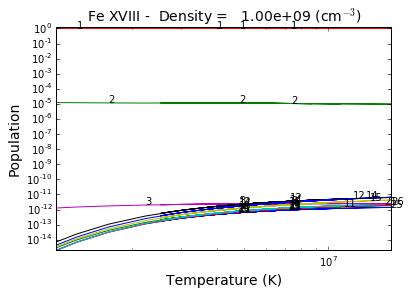

In [64]:
fe18.popPlot()

 ndens =     1 ntemp =  5000
 - make a selection from these - 
     0      91.0411   29   98 2s2.2p4(1D).3p 2P1.5 - 2s.2p5(1P).3p 2S0.5 
     1      91.9888   54  104 2s2.2p4(1D).3d 2F3.5 - 2s.2p5(1P).3d 2F3.5 
     2      93.9322    1    3 2s2.2p5 2P1.5 - 2s.2p6 2S0.5 
 type the comma-separated index/indices of your selection
>>> 2


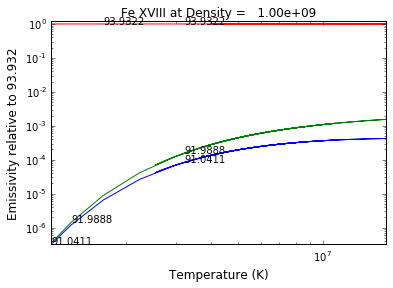

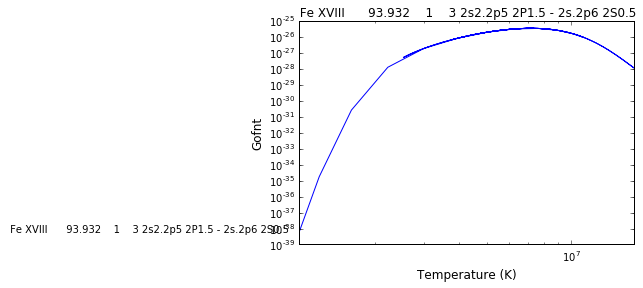

In [67]:
fe18.gofnt(wvlRange=[90,95],top=3)

### Intensity Calculation
First, do some preliminary calculations and allocations.

In [68]:
T_EM = 10**binner.logT_EM
dlogT = binner.logT_EM[1] - binner.logT_EM[0] #assumes uniform spacing
g = np.zeros(len(T_EM))
g_avg = np.zeros(len(t_ebtel))
intensity = np.zeros(len(t_ebtel))
intensity_avg = np.zeros(len(t_ebtel))

In [69]:
ind_g = np.where((T_EM > np.min(fe18.Gofnt['temperature'])) & (T_EM < np.max(fe18.Gofnt['temperature'])))
g[ind_g] = 10.**(np.interp(binner.logT_EM[ind_g],np.log10(fe18.Gofnt['temperature']),np.log10(fe18.Gofnt['gofnt'])))

Now, loop over time and calculate the intensity according to the $\mathrm{DEM}$.

In [70]:
for i in range(len(t_ebtel)):
    intensity[i] = np.log(10.)*dlogT*np.sum(g*T_EM*binner.dem_mat[i,:])

Next, calculate the average intensity according to the density $n$ and temperature $T$.

In [71]:
ind_g_avg = np.where((T_ebtel > np.min(fe18.Gofnt['temperature'])) & (T_ebtel < np.max(fe18.Gofnt['temperature'])))
g_avg[ind_g_avg] = 10.**(np.interp(np.log10(T_ebtel[ind_g]),np.log10(fe18.Gofnt['temperature']),np.log10(fe18.Gofnt['gofnt'])))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  from ipykernel import kernelapp as app


In [72]:
intensity_avg = n_ebtel**2*g_avg*2.*config_dict['loop_length']*1.e+8

Normalize both intensities.

In [78]:
intensity = intensity/np.max(intensity)
intensity_avg = intensity_avg/np.max(intensity_avg)

## Plot Intensity

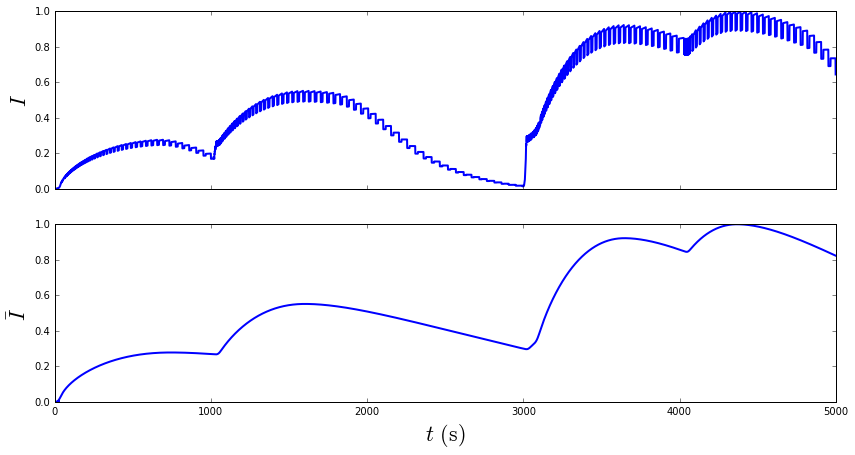

In [79]:
fig,ax = plt.subplots(2,1,figsize=(14,7),sharex=True)
ax[0].plot(t_ebtel,intensity,linewidth=2)
ax[1].plot(t_ebtel,intensity_avg,linewidth=2)
ax[1].set_xlabel(r'$t$ $\mathrm{(s)}$',fontsize=22)
ax[0].set_ylabel(r'$I$',fontsize=22)
ax[1].set_ylabel(r'$\bar{I}$',fontsize=22)
plt.show()

Let's write these to a file so we dont' necessarily have to go through this calculation again.

In [82]:
with open('ebtel_lc_test.intensity','wb') as f:
    pickle.dump([t_ebtel,intensity,intensity_avg],f)
f.close()

In [84]:
with open('ebtel_lc_test.gofnt','wb') as f:
    pickle.dump([fe18.Gofnt['temperature'],fe18.Gofnt['gofnt']],f)
f.close()